In [22]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style = "darkgrid")
mpl.rcParams['figure.figsize'] = (16,9)
pd.set_option('display.max_rows', 500)

# SIR Modeling

- Susceptible, Infectious, Recovery Modeling

In [23]:
df_analyse = pd.read_csv('../data/processed/COVID_small_flat_table.csv', sep = ';')
df_analyse.sort_values('date', ascending = True).head()

,date,Italy,US,Spain,Germany,"Korea, South"
0,2020-01-22,0,1,0,0,1
1,2020-01-23,0,1,0,0,1
2,2020-01-24,0,2,0,0,2
3,2020-01-25,0,2,0,0,2
4,2020-01-26,0,5,0,0,3


In [24]:
# Setting some basic parameters for the SIR modeling forumale
N0 = 1000000
# Reproduction rate
beta = 0.4
# 1 person can infect 4 persons
gamma = 0.1

# Starting infection size
# Sum of the below three should be equal to N0
I0 = df_analyse.Germany[35] #27
S0 = N0 - I0
R0 = 0

In [25]:
def SIR_model(SIR, beta, gamma):
    
    S,I,R = SIR
    dS_dt = -beta*S*I/N0
    dI_dt = (beta*S*I/N0)-(gamma*I)
    dR_dt = gamma*I
    return ([dS_dt, dI_dt, dR_dt])

## Simulative approach to calculate SIR curves

In [29]:
SIR = np.array([S0, I0, R0])
propogation_rates = pd.DataFrame(columns={'susceptible':S0,
                                         'infected':I0,
                                         'recovered':R0})
#print(SIR)
print(propogation_rates)

    

Empty DataFrame
Columns: [susceptible, infected, recovered]
Index: []


In [37]:
for each_t in np.arange(50):# 50 timesteps
    new_delta_vec = SIR_model(SIR, beta, gamma)
    #print(new_delta_vec)
    SIR = SIR+new_delta_vec
    #print(SIR)
    propogation_rates = propogation_rates.append({'susceptible': SIR[0],
                                                 'infected': SIR[1],
                                                 'recovered': SIR[2]}, ignore_index = True)
propogation_rates.head()

,susceptible,infected,recovered
0,999962.200292,35.099708,2.700000
1,999948.160939,45.629090,6.209971
2,999929.910249,59.316871,10.772880
3,999906.185164,77.110269,16.704567
4,999875.343949,100.240457,24.415594


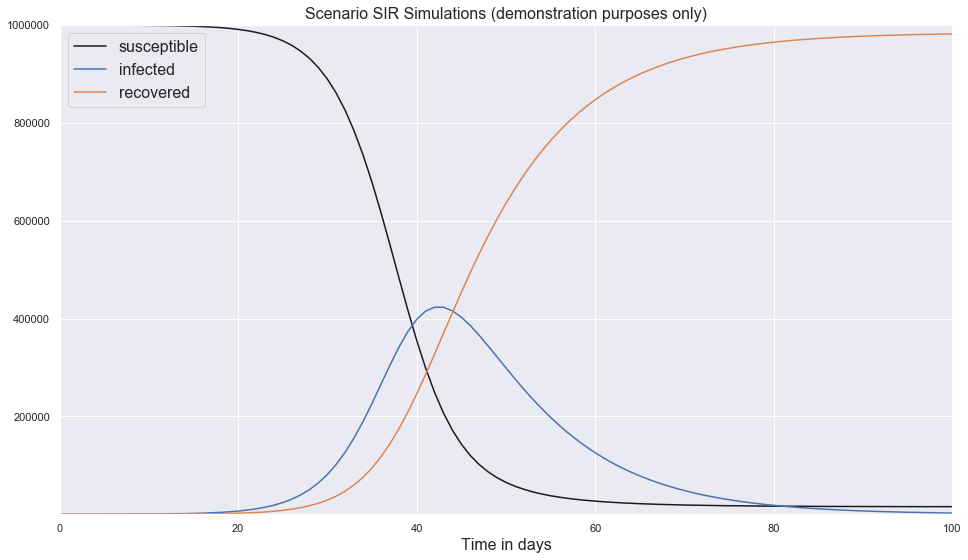

In [46]:
fig, axl = plt.subplots(1,1)
 
axl.plot(propogation_rates.index, propogation_rates.susceptible, label = 'susceptible', color = 'k')
axl.plot(propogation_rates.index, propogation_rates.infected, label = 'infected')
axl.plot(propogation_rates.index, propogation_rates.recovered, label = 'recovered')

axl.set_ylim(10,1000000)
axl.set_yscale('linear')
axl.set_title('Scenario SIR Simulations (demonstration purposes only)', size = 16)
axl.set_xlabel('Time in days', size = 16)
# Below line can be commented out later
axl.set_xlim(0,100)
axl.legend(loc = 'best',
          prop = {'size':16})

- Above graph shows in model of covid infections starting from 27 people
- Withing 100 days 1 Million people are infected
- But it depends on the beta, and gamma rate
- The above rates and differential equations should now be fitted to our data

## Fitting the parameters of SIR model

In [90]:
ydata = np.array(df_analyse.Germany[35:])
t = np.arange(len(ydata))

In [91]:
# Infected
I0 = ydata[0]
S0 = N0 - I0
R0 = 0
beta

0.4

In [92]:
def SIR_model_t(SIR, t, beta, gamma):# integrate over time
    S,I,R = SIR
    dS_dt = -beta*S*I/N0
    dI_dt = beta*S*I/N0-gamma*I
    dR_dt = gamma*I
    return dS_dt, dI_dt, dR_dt

In [93]:
## Fit ordinary differential equation
def fit_odeint(x, beta, gamma): # x = t
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args = (beta, gamma))[:,1] # only the infected I

In [94]:
popt = [0.4, 0.1]
fit_odeint(t, *popt)

array([2.70000000e+01, 3.64457071e+01, 4.91956207e+01, 6.64053493e+01,
       8.96344660e+01, 1.20987564e+02, 1.63304428e+02, 2.20416326e+02,
       2.97491205e+02, 4.01498275e+02, 5.41832616e+02, 7.31153728e+02,
       9.86509149e+02, 1.33083608e+03, 1.79496099e+03, 2.42024936e+03,
       3.26209305e+03, 4.39445723e+03, 5.91573047e+03, 7.95611026e+03,
       1.06866705e+04, 1.43300301e+04, 1.91720581e+04, 2.55731545e+04,
       3.39761277e+04, 4.49053964e+04, 5.89492486e+04, 7.67139399e+04,
       9.87375269e+04, 1.25356226e+05, 1.56531317e+05, 1.91671801e+05,
       2.29519056e+05, 2.68172791e+05, 3.05306626e+05, 3.38543581e+05,
       3.65876662e+05, 3.85989183e+05, 3.98379367e+05, 4.03287154e+05,
       4.01494345e+05, 3.94088591e+05, 3.82258097e+05, 3.67146745e+05,
       3.49770632e+05, 3.30982618e+05, 3.11468385e+05, 2.91760020e+05,
       2.72257377e+05, 2.53251232e+05, 2.34945074e+05, 2.17474127e+05,
       2.00921199e+05, 1.85329524e+05, 1.70712933e+05, 1.57063815e+05,
      

In [95]:
# Getting the optimal parameters
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))

print('standard deviation errors:', str(perr), 'start infect:', ydata[0])
print("Optimal parameters:beta = ", popt[0], " and gamma = ", popt[1])

/Users/vimstan/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors: [0.00544512 0.00505256] start infect: 27
Optimal parameters:beta =  0.2916240377590026  and gamma =  0.12259210351127664


In [96]:
# Getting the final fitted curve
fitted = fit_odeint(t, *popt)

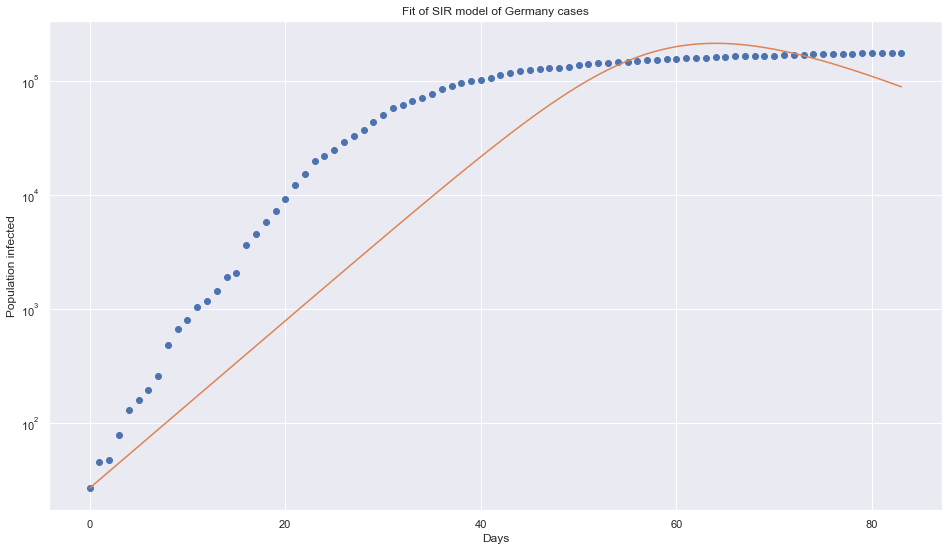

Optimal parameters:beta =  0.2916240377590026  and gamma =  0.12259210351127664
Basic Reproduction Number R0:  2.3788158405502644


In [97]:
# Make a plot with log scaling on the y axis.
plt.semilogy(t, ydata, 'o') # 'o' is circle shaped points
plt.semilogy(t, fitted)
plt.title("Fit of SIR model of Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters:beta = ", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0: ", popt[0]/popt[1])

- This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible). @wiki

## Dynamic beta in SIR (infection rate)

In [118]:
t_initial = 28 # days
t_intro_measures = 14 # Ramping down the infection rate after 14 days
t_hold = 21
t_relax = 21

beta_max = 0.4
beta_min = 0.11
gamma = 0.1
# Merging two arrays -> concatenate
# Linspace -> Return evenly spaced numbers
pd_beta = np.concatenate((np.array(t_initial*[beta_max]), # 21 times beta_max
                         np.linspace(beta_max, beta_min,t_intro_measures),
                         np.array(t_hold*[beta_min]),
                         np.linspace(beta_min, beta_max, t_relax),# infection rate rises after rule relaxation
                         ))
pd_beta

array([0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.37769231,
       0.35538462, 0.33307692, 0.31076923, 0.28846154, 0.26615385,
       0.24384615, 0.22153846, 0.19923077, 0.17692308, 0.15461538,
       0.13230769, 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.1245    ,
       0.139     , 0.1535    , 0.168     , 0.1825    , 0.197     ,
       0.2115    , 0.226     , 0.2405    , 0.255     , 0.2695 

In [119]:
SIR = np.array([S0, I0, R0])
propogation_rates = pd.DataFrame(columns = {'susceptible':S0,
                                           'infected':I0,
                                           'recovered':R0})

for each_beta in pd_beta:
    new_delta_vec = SIR_model(SIR, each_beta, gamma)
    SIR = SIR+new_delta_vec
    propogation_rates = propogation_rates.append({'susceptible':SIR[0],
                                                 'infected':SIR[1],
                                                 'recovered':SIR[2]}, ignore_index = True)

array([28, 42, 63, 84])

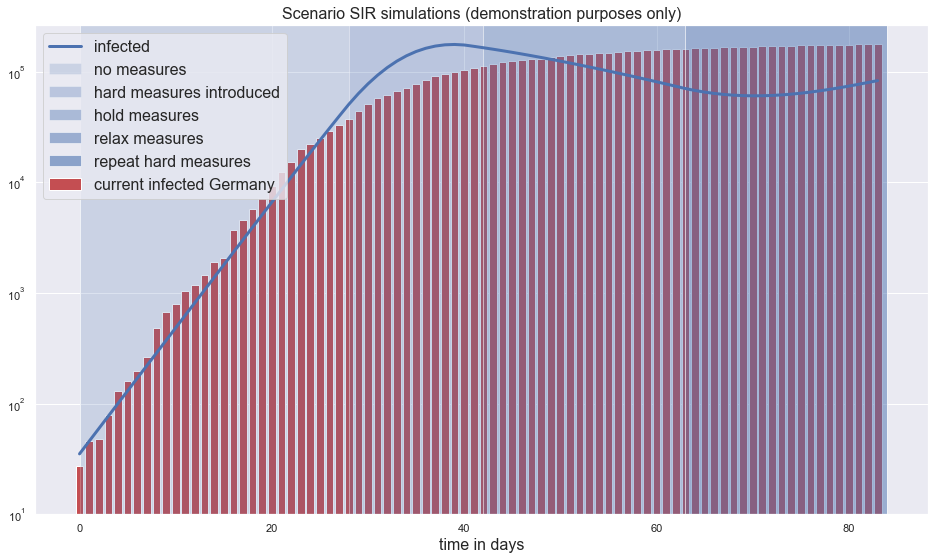

In [120]:
fig, axl = plt.subplots(1,1)

axl.plot(propogation_rates.index, propogation_rates.infected, label = 'infected', linewidth = 3)
t_phases = np.array([t_initial, t_intro_measures, t_hold, t_relax]).cumsum()

axl.bar(np.arange(len(ydata)), ydata, width = 0.8, label = 'current infected Germany', color = 'r')

# Add a vertical span (rectangle) across the axes
axl.axvspan(0, t_phases[0], facecolor = 'b', alpha = 0.2, label = 'no measures')
axl.axvspan(t_phases[0], t_phases[1], facecolor = 'b', alpha = 0.3, label = 'hard measures introduced')
axl.axvspan(t_phases[1], t_phases[2], facecolor = 'b', alpha = 0.4, label = 'hold measures')
axl.axvspan(t_phases[2], t_phases[3], facecolor = 'b', alpha = 0.5, label = 'relax measures')
axl.axvspan(t_phases[3], len(propogation_rates.infected), facecolor = 'b', alpha = 0.6, label = 'repeat hard measures')

axl.set_ylim(10, 1.5*max(propogation_rates.infected))
axl.set_yscale('log')
axl.set_title('Scenario SIR simulations (demonstration purposes only)', size = 16)
axl.set_xlabel('time in days', size = 16)
axl.legend(loc = 'best',
          prop = {'size':16});

t_phases